## Kết nối đến thư mục Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/EdgeAIK03/M11K03_EdgeAI_MachineLearning_1'
os.chdir(project_path)

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/EdgeAIK03/M11K03_EdgeAI_MachineLearning_1


### Đọc Data và chia nhóm

#### Load data từ File đã trích xuất đặc trưng từ trước

In [39]:
import numpy as np

labels = ["Norm", "Fall"]

X = np.load('fall_detection/data_in.npy')
y = np.load('fall_detection/data_lb.npy')

print(X.shape)
print(y.shape)
print(y)

(158, 9)
(158,)
[0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0
 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1
 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0
 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 0 1 1 1 1 0 1 0 1 0]


#### Chia tập dữ liệu thành tập Train (70%), Validation (20%) và Test (10%)

In [53]:
from sklearn.preprocessing import LabelEncoder
import random
from tensorflow.keras.utils import to_categorical


train_split_rate =0.8

labels, counts = np.unique(y, return_counts=True)

X_train = []
y_train = []

X_test = []
y_test = []

for lb, count in zip(labels.tolist(), counts.tolist()):
  idx_lst = np.where(y == lb)[0]

  # Randomize indexes
  random.shuffle(idx_lst)

  # Divide the indexes into Train and Test
  train_count = int(len(idx_lst) * train_split_rate)

  # Split the features with the same indexes
  X_train.append(np.take(X, idx_lst[:train_count], axis=0))
  y_train.append(np.take(y, idx_lst[:train_count], axis=0))
  X_test.append(np.take(X, idx_lst[train_count:], axis=0))
  y_test.append(np.take(y, idx_lst[train_count:], axis=0))

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Print status
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t y train shape: {}".format(y_test.shape, y_train.shape))

# 10 nhãn: [1, 5, 7] => [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],...] # one hot

le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))
print(y_test_encoded.shape)
print(y_train_encoded.shape)

X test shape: (33, 9) 	 X train shape: (125, 9)
y test shape: (33,) 	 y train shape: (125,)
(33, 2)
(125, 2)


### Tạo Model

#### Cấu hình Model

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

In [57]:
input_shape = 9
output_shape = 2

In [58]:
# Total number of labels to predict (equal to the network output nodes)

model = Sequential([
  Dense(12, activation='relu', input_shape=(input_shape,)),
  Dense(9, activation='relu'),
  Dropout(0.2),
  Dense(output_shape, activation='sigmoid', name="outputs")
])

In [59]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 12)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │             117 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 2)                   │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

### Tạo Loss Function, Optimizer, Training

#### Thiết lập thông số Train

In [64]:
learning_rate = 0.005  # Tốc độ học
epochs = 1000  # Số chu kỳ huấn luyện
batch_size = 32  # Số dữ liệu cho 1 batch

#### Huấn luyện

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class EpochLogger(Callback):
    def __init__(self, display_step):
        super(EpochLogger, self).__init__()
        self.display_step = display_step

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_step == 0:
            print(f"Epoch {epoch + 1}/{self.params['epochs']} - loss: {logs['loss']:.4f}, accuracy: {logs['accuracy']:.4f}" + \
                  (f", val_loss: {logs['val_loss']:.4f}, val_accuracy: {logs['val_accuracy']:.4f}" if 'val_loss' in logs else ""))


early_stopping = EarlyStopping(
    monitor="val_loss",  # Theo dõi giá trị 'val_loss'
    patience=500,         # Số epoch chờ trước khi dừng
    verbose=1,           # Hiển thị thông báo khi dừng
    restore_best_weights=True  # Phục hồi trọng số tốt nhất
)

In [62]:
from tensorflow.keras.optimizers import Adam

epoch_logger = EpochLogger(display_step=5)
checkpoint = ModelCheckpoint(filepath="fall_detection/best_model.keras", monitor="val_loss", save_best_only=True, verbose=0)

opt = Adam(learning_rate=learning_rate) # Thuật toán tối ưu
model.compile(
    loss='categorical_crossentropy', # Function tính loss function
    metrics=['accuracy'], # hiển thị xác suất độ chính xác
    optimizer=opt)

In [67]:
history = model.fit(
    X_train, y_train_encoded,
    epochs=epochs,
    validation_split=0.2, verbose=0,
    batch_size=batch_size, callbacks=[checkpoint, epoch_logger, early_stopping], shuffle=True)

Epoch 5/1000 - loss: 0.6669, accuracy: 0.5700, val_loss: 0.6372, val_accuracy: 0.6400
Epoch 10/1000 - loss: 0.6336, accuracy: 0.7000, val_loss: 0.6953, val_accuracy: 0.6400
Epoch 15/1000 - loss: 0.6055, accuracy: 0.7500, val_loss: 0.7296, val_accuracy: 0.5600
Epoch 20/1000 - loss: 0.5533, accuracy: 0.7900, val_loss: 0.7568, val_accuracy: 0.5200
Epoch 25/1000 - loss: 0.5343, accuracy: 0.8100, val_loss: 0.7704, val_accuracy: 0.4800
Epoch 30/1000 - loss: 0.5261, accuracy: 0.8000, val_loss: 0.7890, val_accuracy: 0.4800
Epoch 35/1000 - loss: 0.4860, accuracy: 0.8200, val_loss: 0.7961, val_accuracy: 0.4800
Epoch 40/1000 - loss: 0.4699, accuracy: 0.8600, val_loss: 0.7774, val_accuracy: 0.5600
Epoch 45/1000 - loss: 0.4527, accuracy: 0.8400, val_loss: 0.7716, val_accuracy: 0.5600
Epoch 50/1000 - loss: 0.4044, accuracy: 0.8800, val_loss: 0.7474, val_accuracy: 0.5600
Epoch 55/1000 - loss: 0.4353, accuracy: 0.8500, val_loss: 0.7279, val_accuracy: 0.5600
Epoch 60/1000 - loss: 0.4026, accuracy: 0.82

#### Vẽ đồ thị quá trình huấn luyện

In [68]:
import matplotlib.pyplot as plt


# Hàm vẽ đồ thị lịch sử huấn luyện
def plot_training_history(history, step=5):
    """
    Vẽ đồ thị lịch sử huấn luyện của mô hình, hiển thị một số epoch nhất định.

    Tham số:
    - history: Kết quả lịch sử huấn luyện từ model.fit().
    - step: Khoảng cách giữa các epoch được hiển thị.
    """
    plt.figure(figsize=(12, 6))

    # Vẽ loss với khoảng cách epoch
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss', color='blue', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

    # Thêm chú thích
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

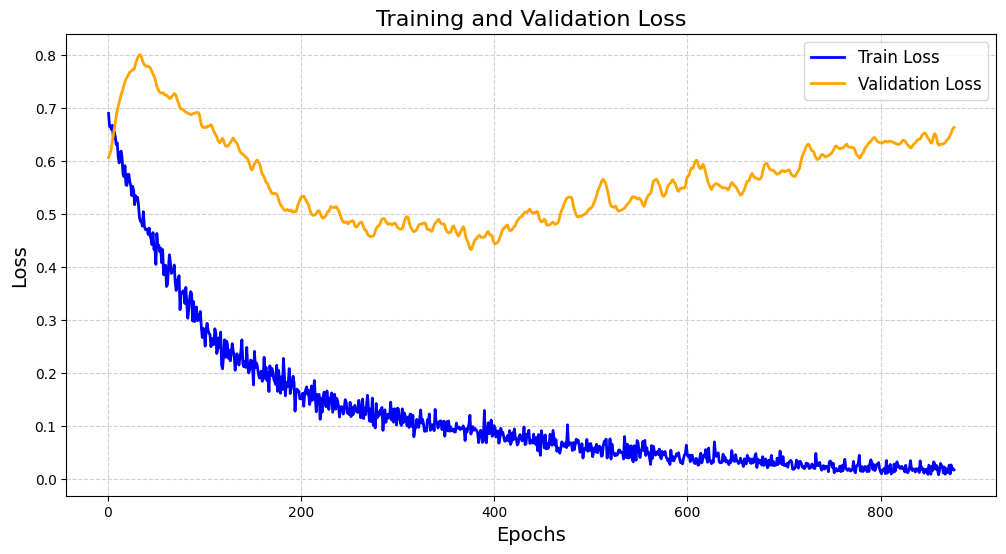

In [69]:
plot_training_history(history, step=10)

#### Đánh giá mô hình

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hàm vẽ confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Vẽ confusion matrix.

    Tham số:
    - y_true: Nhãn thật (ground truth).
    - y_pred: Nhãn dự đoán từ mô hình.
    - class_names: Danh sách tên các phân lớp.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

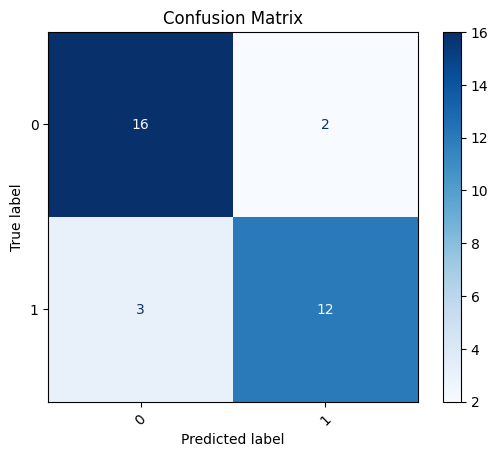

In [76]:
# Đánh giá hiệu năng mô hình nếu có tập validation
metrics = {}
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) # [0, 1, 0, 0, 0 ,0 ,0 ,0 ,0 ] => 1
y_trues = np.argmax(y_test_encoded, axis=1) # [0, 0, 1, 0, 0 ,0 ,0 ,0 ,0 ] => 2
# Add "pred" column
#test_meta['pred'] = yhat_probs

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

plot_confusion_matrix(y_trues, yhat_probs, labels)

In [98]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, num_classes=2):
    """
    Đánh giá mô hình với các chỉ số phân loại chính: AUC, Precision, Recall, F1.

    Tham số:
    - y_true: numpy array, nhãn thực tế (integer).
    - y_pred: numpy array, nhãn dự đoán (integer).
    - num_classes: Số phân lớp (mặc định: 2).

    Trả về:
    - Một dictionary chứa các chỉ số đánh giá.
    """
    # Tính toán các chỉ số đánh giá
    weighted_precision = precision_score(y_true, y_pred, average="weighted")
    weighted_recall = recall_score(y_true, y_pred, average="weighted")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    classification_report_str = classification_report(y_true, y_pred)

    # Trả về các chỉ số
    return {
        "precision": weighted_precision,
        "recall": weighted_recall,
        "f1_score": weighted_f1,
        "classification_report": classification_report_str
    }

In [96]:
print(y_test_encoded.shape, y_probs.shape)

(33, 2) (33, 2)


In [100]:
evaluation_results = evaluate_model(np.argmax(y_test_encoded, axis=1), np.argmax(y_probs, axis=1), num_classes=2)

# Hiển thị kết quả đánh giá
print("Evaluation Results:")
print(f"Weighted Precision: {evaluation_results['precision']:.4f}")
print(f"Weighted Recall: {evaluation_results['recall']:.4f}")
print(f"Weighted F1-Score: {evaluation_results['f1_score']:.4f}")
print("Classification Report:\n", evaluation_results["classification_report"])

Evaluation Results:
Weighted Precision: 0.8489
Weighted Recall: 0.8485
Weighted F1-Score: 0.8479
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86        18
           1       0.86      0.80      0.83        15

    accuracy                           0.85        33
   macro avg       0.85      0.84      0.85        33
weighted avg       0.85      0.85      0.85        33



#### Chạy thử mô hình

In [101]:
idx = random.randint(0, X_test.shape[0])
print(f'y_target: {y_test_encoded[idx]} | y_predict: {model.predict(np.expand_dims(X_test[idx], axis=0), verbose=0).squeeze()}')

y_target: [0. 1.] | y_predict: [0.03 0.97]
